<a href="https://colab.research.google.com/github/cagdastopcu/convolutional-wavelet-packet-autoencoder-for-dbs-recordings/blob/main/step_001_dbs_macro_autoen_active.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import os
import tarfile
import PIL
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from scipy.interpolate import interp1d

from scipy.stats import boltzmann
import scipy.stats as stats


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
subNames = ['210319','210413','210505','210527',
            '210708','210805','210909']

sub_name = subNames[0]

wpte = np.load('/content/gdrive/My Drive/dbs_macro_active/dbs_macro_wpte/DBS_sub_210909_macro_4khz_9sec_ENCODE_filt_wpte.npy')

In [ ]:
print(wpte.shape)

(120, 6, 516, 201)


In [ ]:
chan00 = wpte[:,0,3:73,66:136]
print(chan00.shape)
data = chan00
data = torch.from_numpy(data)
#print(data)


(120, 70, 70)


In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0001
BATCH_SIZE = 1
NUM_EPOCHS = 50

Device: cuda:0


In [ ]:
##########################
### MODEL - new
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :70, :70]
        #return torch.squeeze(x[:, :, :128, :128],0)


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                #nn.MaxPool2d(2, 2),
                nn.Flatten(),
                nn.Linear(20736, 64)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(64, 20736),
                Reshape(-1, 64, 18, 18),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                #nn.ConvTranspose2d(32, 1, stride=(3, 3), kernel_size=(2, 2), padding=1), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def compute_epoch_loss_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [ ]:
def train_autoencoder_v1(num_epochs, model, optimizer, device, 
                         train_loader, loss_fn=None,
                         logging_interval=100, 
                         skip_epoch_stats=False,
                         save_model=None):
    
    log_dict = {'train_loss_per_batch': [],
                'train_loss_per_epoch': []}
    
    if loss_fn is None:
        loss_fn = F.mse_loss
        #loss_fn = nn.BCELoss()

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        #for batch_idx, (features, _) in enumerate(train_loader):
        for batch_idx, features in enumerate(train_loader):
            features = features[None,:,:,:]
            features = features.to(device)
            #print(features.shape)

            # FORWARD AND BACK PROP
            logits = model(features)
            #print(logits.shape)
            loss = loss_fn(logits, features)
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_loss_per_batch'].append(loss.item())
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_loss_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict

In [ ]:
print(type(wpte))
print(wpte.shape)

print(np.reshape(wpte,(120*6,1,516,201)).shape)

chan_data = wpte[:,0,3:73,66:136]
print(chan_data.shape)

<class 'numpy.ndarray'>
(120, 6, 516, 201)
(720, 1, 516, 201)
(120, 70, 70)


In [ ]:
# Create training and test dataloaders

num_workers = 2
# how many samples per batch to load
batch_size = 1
wpte_ch_shape = np.reshape(wpte,(120*6,1,516,201),order='F')
chan_data = wpte_ch_shape[:,0,3:73,66:136]

#chan_data = wpte[:,0,3:73,66:136]

print(chan_data.shape)
data = chan_data
data = torch.from_numpy(data)

train_data = stats.zscore(data, axis=2, ddof=1)
train_data = train_data
#train_data = train_data - train_data.min()
#train_data = train_data/train_data.max()
#train_data = data/data.max()
#test_data = group_b[:20,:,:]/group_b.max()

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
print(train_loader)
#print(test_loader)

(720, 70, 70)


tensor(-4.1531)


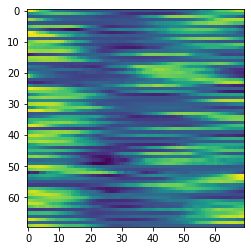

In [ ]:
plt.imshow(train_data[6,:,:])
print(train_data.min())



In [ ]:
model = AutoEncoder()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [ ]:
log_dict = train_autoencoder_v1(num_epochs=NUM_EPOCHS, model=model, 
                                optimizer=optimizer, device=DEVICE, 
                                train_loader=train_loader,
                                skip_epoch_stats=True,
                                logging_interval=250)

Epoch: 001/050 | Batch 0000/0720 | Loss: 1.2275
Epoch: 001/050 | Batch 0250/0720 | Loss: 0.9847
Epoch: 001/050 | Batch 0500/0720 | Loss: 0.9671
Time elapsed: 0.19 min
Epoch: 002/050 | Batch 0000/0720 | Loss: 0.9225
Epoch: 002/050 | Batch 0250/0720 | Loss: 0.9466
Epoch: 002/050 | Batch 0500/0720 | Loss: 0.6990
Time elapsed: 0.26 min
Epoch: 003/050 | Batch 0000/0720 | Loss: 0.9026
Epoch: 003/050 | Batch 0250/0720 | Loss: 0.9145
Epoch: 003/050 | Batch 0500/0720 | Loss: 0.6937
Time elapsed: 0.34 min
Epoch: 004/050 | Batch 0000/0720 | Loss: 0.8845
Epoch: 004/050 | Batch 0250/0720 | Loss: 0.8651
Epoch: 004/050 | Batch 0500/0720 | Loss: 0.6782
Time elapsed: 0.42 min
Epoch: 005/050 | Batch 0000/0720 | Loss: 0.8590
Epoch: 005/050 | Batch 0250/0720 | Loss: 0.8083
Epoch: 005/050 | Batch 0500/0720 | Loss: 0.6542
Time elapsed: 0.50 min
Epoch: 006/050 | Batch 0000/0720 | Loss: 0.8373
Epoch: 006/050 | Batch 0250/0720 | Loss: 0.7571
Epoch: 006/050 | Batch 0500/0720 | Loss: 0.6167
Time elapsed: 0.58 mi

In [ ]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

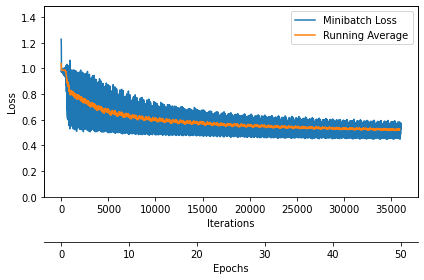

In [ ]:
plot_training_loss(log_dict['train_loss_per_batch'], NUM_EPOCHS)
plt.show()

In [ ]:
device = DEVICE
test_data = torch.zeros((180,128,128))/100
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
model.eval()
embedding = torch.zeros((180,64,2))
with torch.no_grad():
  for idx, features in enumerate(train_loader):

   features = features[None,:,:,:]

   features = features.to(device)
   #print(features.shape)
            
   embedding[idx] = model.encoder(features)

embedding_test = torch.zeros((180,64,8))

with torch.no_grad():
  for idx, features in enumerate(test_loader):

   features = features[None,:,:,:]

   features = features.to(device)
   #print(features.shape)
            
   embedding_test[idx] = model.encoder(features)

embedding.shape

embed_temp1 = torch.Tensor.cpu(embedding)

embed_temp2 = torch.Tensor.cpu(embedding_test)
#for idx in range(10):
  #plt.imshow(embed_temp[idx,:,:].detach().numpy())
#bar = plt.colorbar()
  #plt.show()
#print(train_loader)
#print(train_loader.dataset.shape)
print(torch.sum(embedding))
print(torch.sum(embedding_test))

plt.imshow(embed_temp1[0,:,:].detach().numpy())
plt.show()
plt.imshow(embed_temp2[0,:,:].detach().numpy())
plt.show()

RuntimeError: ignored

In [ ]:
device = DEVICE
embedding = torch.zeros((720,64))
with torch.no_grad():
  for idx, features in enumerate(train_loader):

   features = features[None,:,:,:]
   #print(idx)

   features

   features = features.to(device)
   embedding[idx] = model.encoder(features)


print(embedding.shape)

#embed_temp1 = torch.Tensor.cpu(embedding)
#print(embed_temp1)

torch.Size([720, 64])


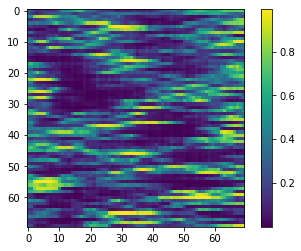

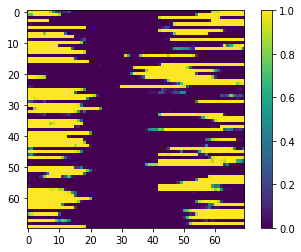

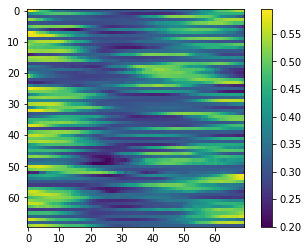

In [ ]:
with torch.no_grad():
    new_image = model.decoder(10*torch.randn(1,64).to(DEVICE))
    #new_image = model.decoder(embedding[0,:].to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy())
bar = plt.colorbar()
plt.show()

word_no = 6
with torch.no_grad():
    #new_image = model.decoder(torch.randn(1,64).to(DEVICE))
    new_image = model.decoder(embedding[word_no,:].to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy())
bar = plt.colorbar()
plt.show()
from scipy import stats
test_data = stats.zscore(data, axis=2, ddof=1)
test_data = test_data - test_data.min()
test_data = test_data/test_data.max()
#test_data = data/data.max()
plt.imshow(test_data[word_no,:,:])
bar = plt.colorbar()
plt.show()

In [ ]:
### GMM

embed_temp = torch.Tensor.cpu(embedding)

from sklearn.mixture import GaussianMixture
# Suppose Data X is a 2-D Numpy array (One apple has two features, size and flavor)
GMM = GaussianMixture(n_components=2, random_state=0).fit(embed_temp)
print(GMM)

active_epoch = GMM.predict(embed_temp)
#print(np.sum(active_epoch))
#print(np.sum(train_data[np.argwhere(active_epoch>0),:,:]))

#print(torch.mean(data[np.argwhere(active_epoch==3),:,:]))
#print(data[np.argwhere(active_epoch==3),:,:].shape[0])

#print(torch.mean(data[np.argwhere(active_epoch==2),:,:]))
#print(data[np.argwhere(active_epoch==2),:,:].shape[0])

print(torch.mean(data[np.argwhere(active_epoch==1),:6,:]))
print(data[np.argwhere(active_epoch==1),:,:].shape[0])

print(torch.mean(data[np.argwhere(active_epoch==0),:6,:]))
print(data[np.argwhere(active_epoch==0),:,:].shape[0])

#print(active_epoch[3])

GaussianMixture(n_components=2, random_state=0)
tensor(2177.4690)
273
tensor(1950.3381)
447


In [ ]:
import seaborn as sns
import pandas as pd
group1_mean = torch.mean(data[np.argwhere(active_epoch==1),:7,:],axis=2)
print(group1_mean.shape)
group1 = torch.flatten(group1_mean)


#group1 = torch.flatten(data[np.argwhere(active_epoch==1),:7,:])
print(group1.shape)
threshold = 500
#group1 = group1[np.where(group1 < threshold)]

group2_mean = torch.mean(data[np.argwhere(active_epoch==0),:7,:],axis=2)

group2 = torch.flatten(group2_mean)

#group2 = torch.flatten(data[np.argwhere(active_epoch==0),:7,:])
print(group2.shape)
#group2 = group2[np.where(group2 < threshold)]

print(torch.flatten(data[np.argwhere(active_epoch==1),:7,:]).shape)
print(torch.flatten(data[np.argwhere(active_epoch==0),:7,:]).shape)



torch.Size([273, 1, 70])
torch.Size([19110])
torch.Size([31290])
torch.Size([133770])
torch.Size([219030])


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


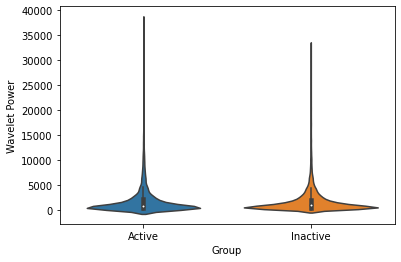

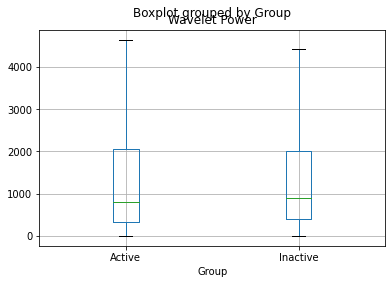

In [ ]:
groups =  ['Active']*19110 + ['Inactive']*31290


data_col = np.hstack((group1,group2))

df = pd.DataFrame({'Wavelet Power':data_col,'Group':groups})

fig, ax = plt.subplots()

ax = sns.violinplot(x="Group", y="Wavelet Power", data=df, ax=ax)
df.boxplot('Wavelet Power',by = 'Group',showfliers=False)

In [ ]:
active_epoch[6]

1

In [ ]:
print(np.sum(train_data)

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler

def get_dataloaders_mnist(batch_size, num_workers=0,
                          validation_fraction=None,
                          train_transforms=None, test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=train_transforms,
                                   download=True)

    valid_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=test_transforms)

    test_dataset = datasets.MNIST(root='data',
                                  train=False,
                                  transform=test_transforms)

    if validation_fraction is not None:
        num = int(validation_fraction * 60000)
        train_indices = torch.arange(0, 60000 - num)
        valid_indices = torch.arange(60000 - num, 60000)

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)
    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  shuffle=True)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader

In [ ]:
##########################
### Dataset
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    validation_fraction=0.)

In [ ]:
print(train_loader.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
for batch_idx, (features, _) in enumerate(train_loader):

            print(features.shape)

ValueError: ignored

In [ ]:
for batch_idx, features in enumerate(train_loader):

            print(features.shape)

torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([1, 128, 108])
torch.Size([

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [ ]:
!cat /proc/meminfo

MemTotal:       13298580 kB
MemFree:        10019192 kB
MemAvailable:   11988500 kB
Buffers:          115028 kB
Cached:          1950996 kB
SwapCached:            0 kB
Active:          1513096 kB
Inactive:        1519236 kB
Active(anon):     865416 kB
Inactive(anon):      452 kB
Active(file):     647680 kB
Inactive(file):  1518784 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               264 kB
Writeback:             0 kB
AnonPages:        966408 kB
Mapped:           232744 kB
Shmem:              1200 kB
KReclaimable:      88592 kB
Slab:             137532 kB
SReclaimable:      88592 kB
SUnreclaim:        48940 kB
KernelStack:        5024 kB
PageTables:        14216 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6649288 kB
Committed_AS:    3059952 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       47120 kB
VmallocChunk:          0 kB
Percpu:          

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   39G   40G  50% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  812M  59% /sbin/docker-init
tmpfs           6.4G   28K  6.4G   1% /var/colab
/dev/sda1        86G   44G   43G  51% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [ ]:
subNames = ['210319','210413','210505','210527',
            '210708','210805','210909']

In [ ]:
import numpy as np 

sub_name = subNames[0]

wpte = np.load('DBS_sub_210319_macro_4khz_9sec_ENCODE_filt_wpte.npy')

In [ ]:
print(wpte[0,0,:,:])

[[1.38353973e+02 8.41194458e+01 5.03306923e+01 ... 4.53613625e+01
  6.76928101e+01 1.00093544e+02]
 [1.86728333e+02 1.69467331e+02 1.57162949e+02 ... 2.29720306e+02
  2.61724396e+02 3.02297180e+02]
 [3.58003693e+01 3.65970917e+01 3.39014282e+01 ... 5.44893122e+00
  5.68185997e+00 5.63065243e+00]
 ...
 [1.08045759e-02 8.49502813e-03 6.69032894e-03 ... 2.54265033e-04
  2.94888770e-04 3.49074457e-04]
 [4.97492962e-03 4.78560012e-03 3.87501135e-03 ... 2.07521225e-04
  2.23285635e-04 2.29073761e-04]
 [1.82621251e-03 1.72858674e-03 1.70090969e-03 ... 9.64025821e-05
  1.07247070e-04 1.08266184e-04]]


In [ ]:
print(wpte.shape)

(120, 6, 516, 201)
